IMPORT

In [44]:
import matplotlib.pyplot as plt
import os
import re
from glob import glob
import numpy as np
import cv2
import dlib
import datetime as dt
import pandas as pd

Load File

In [45]:
subject_name = '01-01/'
dataset_path = 'PURE/'

img_frame_path = dataset_path + subject_name + subject_name

png_list = glob(img_frame_path + '*.png')
png_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# print(f"First 10 frames: {png_list[:10]}")S
print(f"Length: {len(png_list)}")

Length: 2026


Global Variabel

In [46]:
idx_frame_start = 0
idx_frame_end = len(png_list) - 1
fps = 30
n_segment = 2
left_expand_ratio = 0.25
top_expand_ratio = 0.25

f_cnt = 0
i_cnt = idx_frame_start

In [47]:
detector = dlib.get_frontal_face_detector() # Face detection

In [48]:
face_left, face_top, face_right, face_bottom = 0,0,0,0
mask = None
n_skinpixels = 0

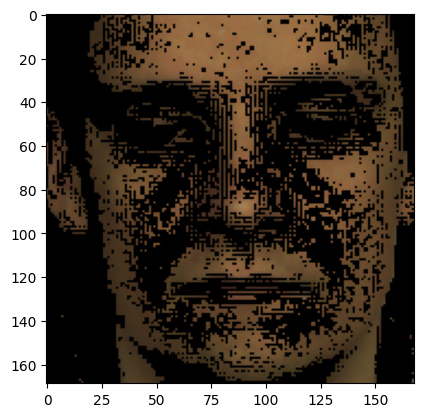

In [6]:
while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end):

    frame = cv2.imread(png_list[i_cnt])
    h, w, _ = frame.shape

    # frame_toshow = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, WidthL {w}")

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #apply face detection
    if f_cnt == 0:
        rect = detector(gray_frame, 0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()

        width = abs (right - left)
        height = abs (bottom - top)
        face_left = int(left - (left_expand_ratio/2 * width))
        face_top = int (top - (top_expand_ratio/2 * height ))
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]

    # frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    # Convert the face region to YCrCb color space
    face_YCrCb = cv2.cvtColor(face, cv2.COLOR_BGR2YCrCb)
    face_hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)

    # Define the skin color range in YCrCb
    lower_skin_YCrCb = np.array([0, 133, 77], dtype=np.uint8)
    upper_skin_YCrCb = np.array([255, 173, 127], dtype=np.uint8)
    mask_YCrCb = cv2.inRange(face_YCrCb, lower_skin_YCrCb, upper_skin_YCrCb)
    # n_skinpixels = np.sum(mask_YCrCb)
    # masked_face = cv2.bitwise_and(face, face, mask=mask_YCrCb)

    # Define the skin color range in HSV
    lower_skin_hsv = np.array([0, 50, 0], dtype=np.uint8)  # Adjust as needed
    upper_skin_hsv = np.array([25, 150, 255], dtype=np.uint8)  # Adjust as needed
    mask_hsv = cv2.inRange(face_hsv, lower_skin_hsv, upper_skin_hsv)
    # n_skinpixels = np.sum(mask_hsv)
    # masked_face = cv2.bitwise_and(face, face, mask=mask_hsv)

    mask_HSCrCb = cv2.bitwise_and(mask_YCrCb, mask_hsv)
    n_skinpixels = np.sum(mask_HSCrCb)
    masked_face = cv2.bitwise_and(face, face, mask=mask_HSCrCb)

    # frame_toshow= cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    #Get the mean RGB value in the skin
    mean_r = np.sum(masked_face[:,:,2]) / n_skinpixels
    mean_g = np.sum(masked_face[:,:,1]) / n_skinpixels
    mean_b = np.sum(masked_face[:,:,0]) / n_skinpixels

    if f_cnt ==0:
        mean_rgb = np.array([mean_r, mean_g, mean_b])
    else:
        mean_rgb = np.vstack((mean_rgb,np.array([mean_r, mean_g, mean_b])))

    # break

    f_cnt += 1
    i_cnt += 1


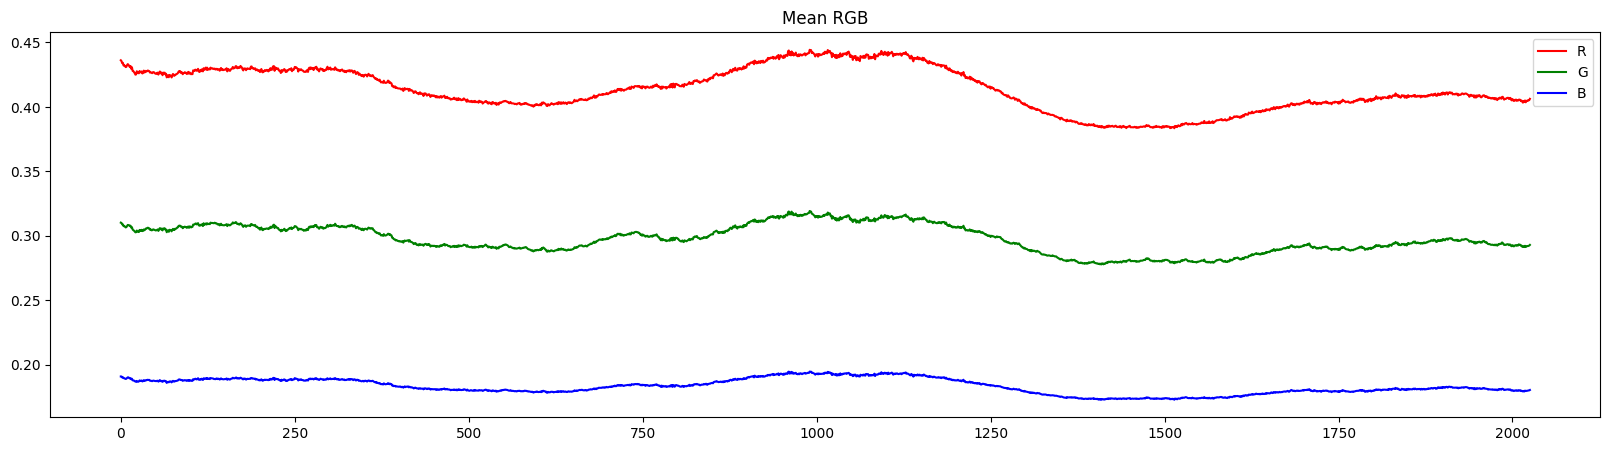

In [7]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb[:,0], label = 'R', color='red')
plt.plot(mean_rgb[:,1], label = 'G', color='green')
plt.plot(mean_rgb[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

POS

In [8]:
l = int(fps * 1.6)
print(f"Window length: {l}")
rPPG_signals = np.zeros(mean_rgb.shape[0])
print(f"rPPG_signals shape: {rPPG_signals.shape}")

Window length: 48
rPPG_signals shape: (2026,)


In [9]:
for t in range (0, mean_rgb.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals[t:t+l-1] = rPPG_signals[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



GRGB

In [10]:
R = mean_rgb[:, 0]
G = mean_rgb[:, 1]
B = mean_rgb[:, 2]

GRGB_signal = (G/R) + (G/B)

# GRGB_signal.shape

Converting Timestamps

In [11]:
timestamps = []

for file_name in png_list:
    # Use regex to extract digits following 'Image' and before '.png'
    match = re.search(r'Image(\d+)\.png', file_name)
    if match:
        timestamps.append(match.group(1))

# print(len(timestamps))

durations = []
for ts in timestamps:
    # Convert nanoseconds to seconds
    timestamp_sec = int(ts) / 1e9

    durations.append(timestamp_sec)


# Print formatted times and original timestamps
# print(len(formatted_times))
first_duration = durations[0]
video_durations = [duration - first_duration for duration in durations]
print(video_durations[:15])
# print(timestamps[:5])

[0.0, 0.03334522247314453, 0.06668901443481445, 0.10000324249267578, 0.1333472728729248, 0.16669225692749023, 0.20000624656677246, 0.23335027694702148, 0.2666943073272705, 0.30000805854797363, 0.33335304260253906, 0.3666670322418213, 0.4000110626220703, 0.43335509300231934, 0.46666908264160156]


Shape of rPPG_signals: (2026,)


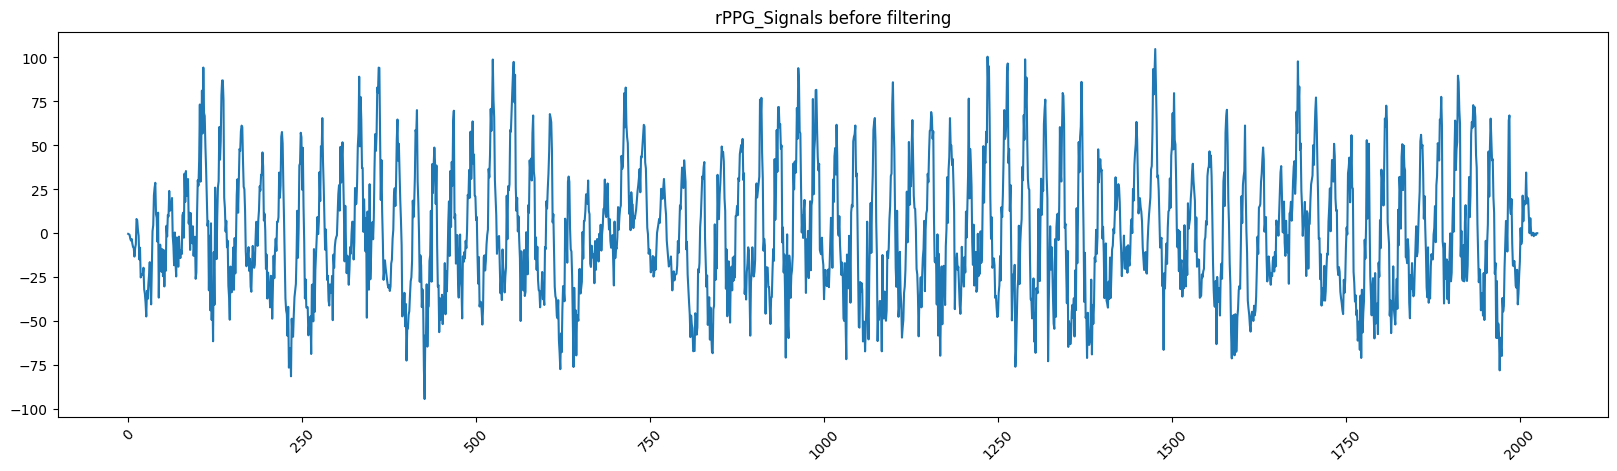

In [12]:
from matplotlib.ticker import MaxNLocator


print(f"Shape of rPPG_signals: {rPPG_signals.shape}")
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, rPPG_signals)
plt.plot(rPPG_signals)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.title(f"rPPG_Signals before filtering")
plt.show()

Shape of GRGB_signals: (2026,)


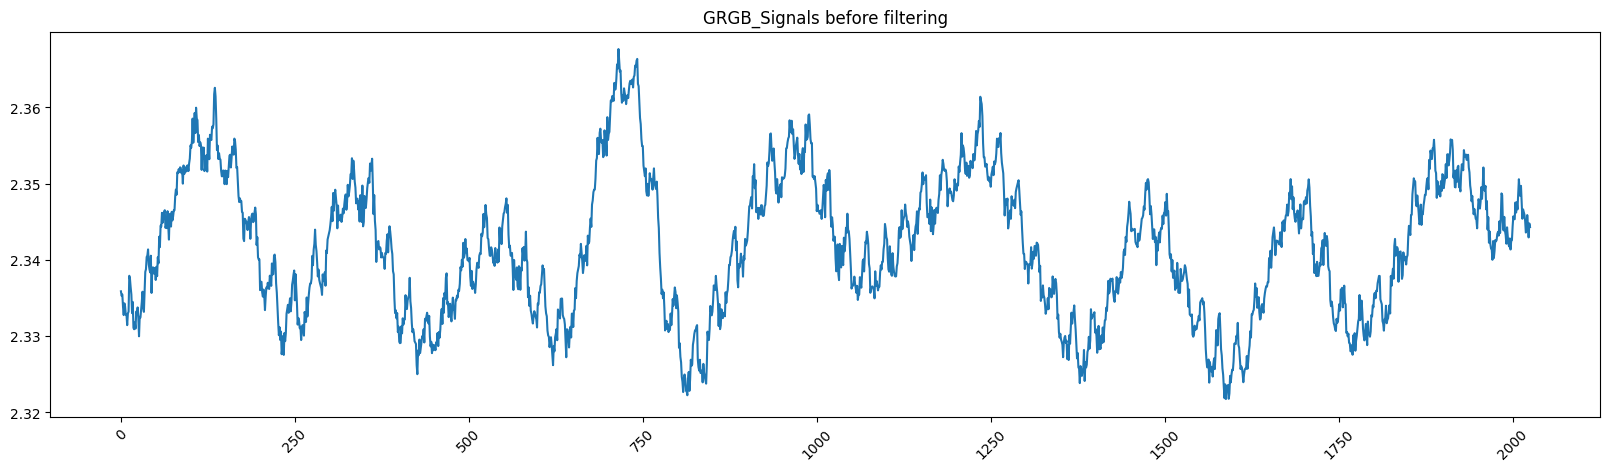

In [13]:
from matplotlib.ticker import MaxNLocator


print(f"Shape of GRGB_signals: {GRGB_signal.shape}")
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, GRGB_signal)
plt.plot(GRGB_signal)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.title(f"GRGB_Signals before filtering")
plt.show()

Shape of rPPG_signals: (2026,)
[ 0.01394419  0.04453895  0.08016469 ... -0.17369317 -0.11937307
 -0.05504426]


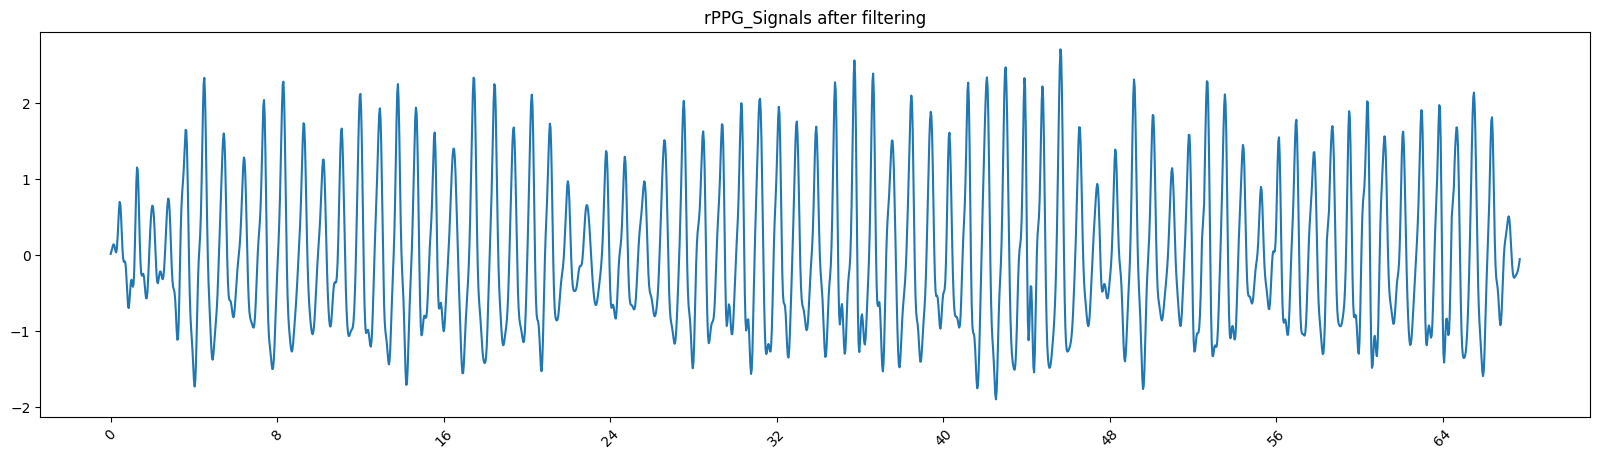

In [14]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
rPPG_filtered = signal.filtfilt(b, a, rPPG_signals)

#standardization
rPPG_filtered = (rPPG_filtered-np.mean(rPPG_filtered))/np.std(rPPG_filtered)

print(f"Shape of rPPG_signals: {rPPG_filtered.shape}")
print(rPPG_filtered)
plt.figure(figsize=(20,5))
plt.plot(video_durations, rPPG_filtered)
# plt.plot(rPPG_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"rPPG_Signals after filtering")
plt.show()

Shape of GRGB_signals: (2026,)
[-0.011846   -0.1628669  -0.258665   ... -0.46928416 -0.316254
 -0.13485274]


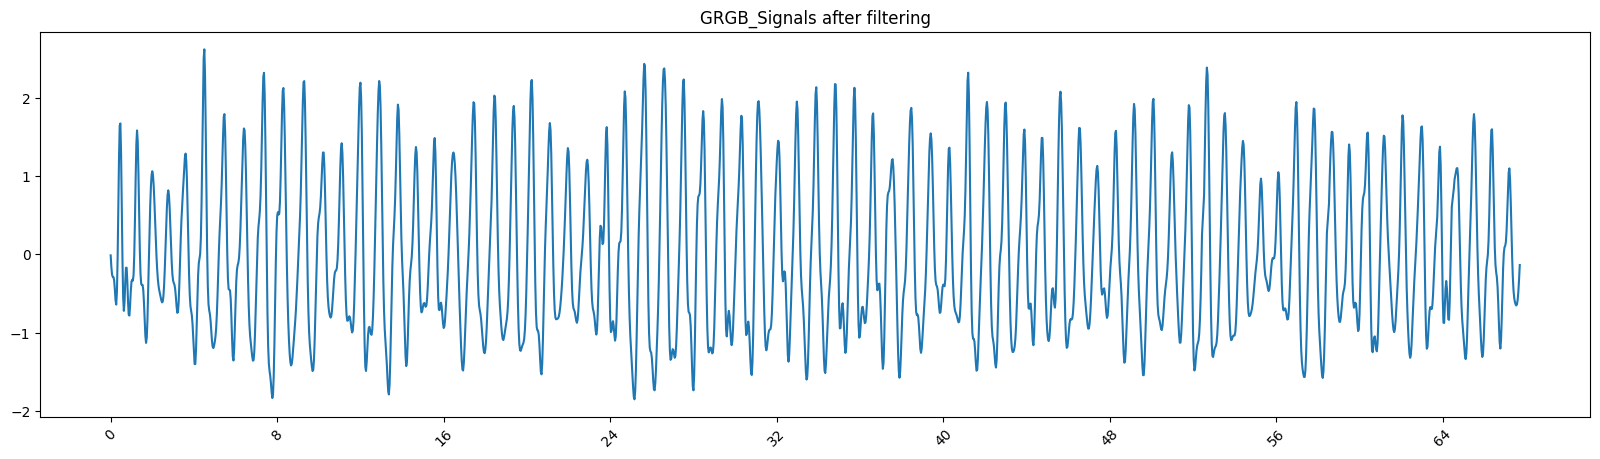

In [15]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
GRGB_filtered = signal.filtfilt(b, a, GRGB_signal)

#standardization
GRGB_filtered = (GRGB_filtered-np.mean(GRGB_filtered))/np.std(GRGB_filtered)

print(f"Shape of GRGB_signals: {GRGB_filtered.shape}")
print(GRGB_filtered)
plt.figure(figsize=(20,5))
plt.plot(video_durations, GRGB_filtered)
# plt.plot(GRGB_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"GRGB_Signals after filtering")
plt.show()

Compare with groundtruth

[0.0, 0.03200721740722656, 0.04800105094909668, 0.06400227546691895, 0.07999825477600098, 0.09600210189819336, 0.11201834678649902, 0.12801623344421387, 0.14397335052490234, 0.15999412536621094, 0.17602920532226562, 0.19223618507385254, 0.22400736808776855, 0.23998212814331055, 0.25600314140319824]
4018


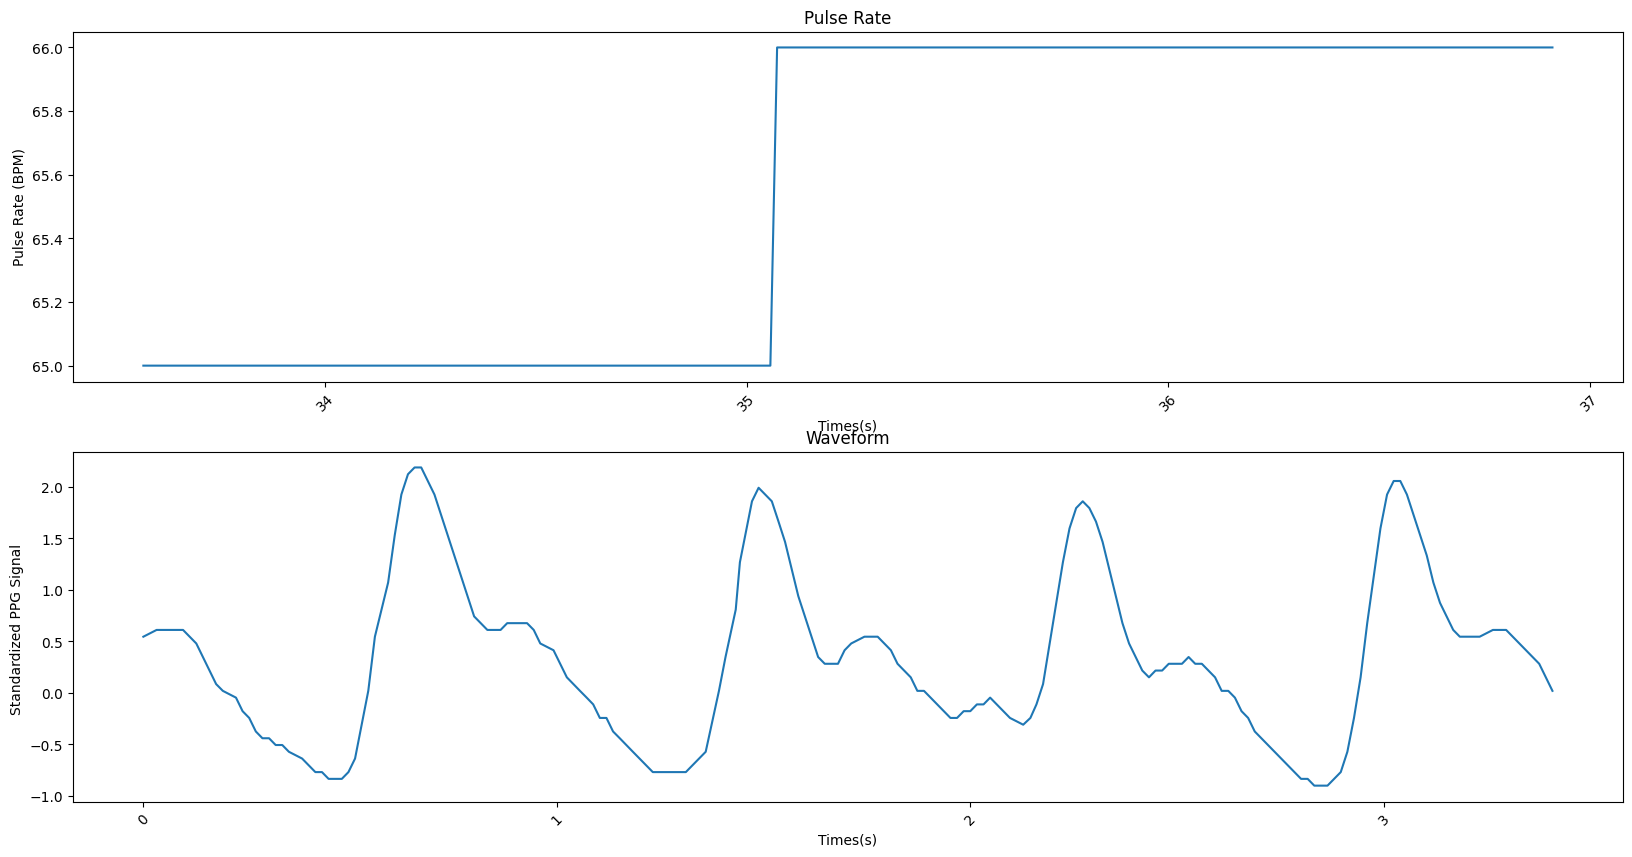

BPM = 70.12518666002987


In [16]:
import json 

gt_path = dataset_path + subject_name +'/01-01.json'

with open (gt_path, 'r') as file:
    data = json.load(file)

full_package_data = data["/FullPackage"]
image_data = data["/Image"]

timestamps_package = [entry["Timestamp"] for entry in full_package_data]
waveform = [entry["Value"]["waveform"] for entry in full_package_data]
pulseRate = [entry["Value"]["pulseRate"] for entry in full_package_data]
frame_package = [entry["FrameID"] for entry in full_package_data]
waveform = (waveform-np.mean(waveform))/np.std(waveform)

# print(timestamps_package[:5])

# Converting Timestamps
duration_packages = []
for ts in timestamps_package:
    # Convert nanoseconds to seconds
    timestamp_sec = int(ts) / 1e9
    
    duration_packages.append(timestamp_sec)


first_duration_package = duration_packages[0]
oxymeter_durations = [duration_package - first_duration_package for duration_package in duration_packages]
print(oxymeter_durations[:15])
print(len(waveform))

plt.figure(figsize=(20,10))
# plt.subplot(2,1,1)
# plt.plot(pulseRate)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
# plt.xticks(rotation=45)  # Rotate labels for better readability

# plt.subplot(2,1,2)
# plt.plot(waveform)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
# plt.xticks(rotation=45)  # Rotate labels for better readability
# plt.show()

#plotting against converted timestamps
# Plot pulse rate
plt.subplot(2, 1, 1)
plt.plot(oxymeter_durations[2000:2200], pulseRate[2000:2200])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title("Pulse Rate")
plt.xlabel("Times(s)")  # Label x-axis
plt.ylabel("Pulse Rate (BPM)")  # Label y-axis with unit

# Plot waveform
plt.subplot(2, 1, 2)
plt.plot(oxymeter_durations[:200], waveform[:200])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title("Waveform")
plt.xlabel("Times(s)")  # Label x-axis
plt.ylabel("Standardized PPG Signal ")  # Label y-axis with unit
plt.show()

print(f"BPM = {np.mean(pulseRate)}")
# print(len(timestamps_package))
# print(len(frame_package))
# print(len(timestamps))
# print(len(frame))

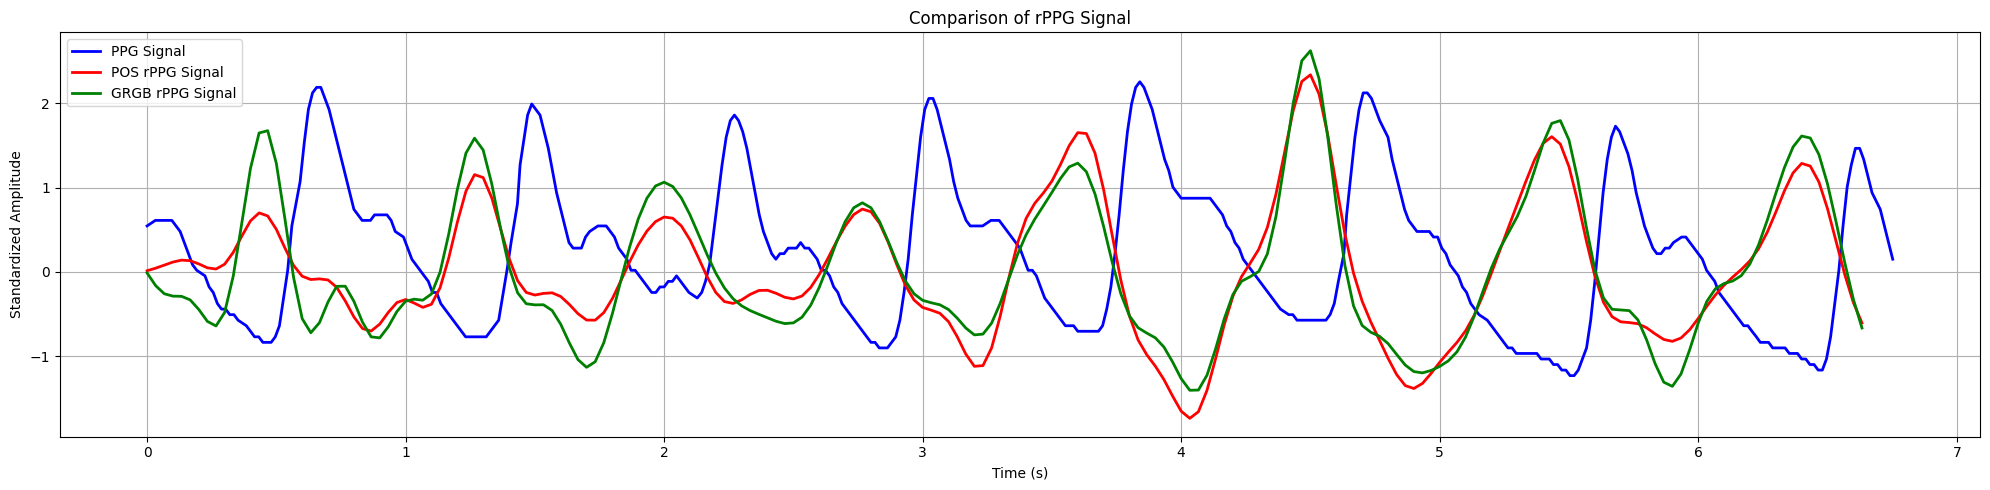

In [17]:
# Plotting the BPM estimates and oxymeter BPM on the same y-axis
plt.figure(figsize=(20, 5))

# Plot BPM estimates from the PPG signal
plt.plot(oxymeter_durations[:400], waveform[:400], color='blue', label='PPG Signal', linewidth=2)

# Plot the oxymeter readings for comparison
plt.plot(video_durations[:200], rPPG_filtered[:200], color='red', label='POS rPPG Signal', linewidth=2)

plt.plot(video_durations[:200], GRGB_filtered[:200], color='green', label='GRGB rPPG Signal', linewidth=2)


# Configure plot
plt.title("Comparison of rPPG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Standardized Amplitude")
plt.legend(loc="upper left")
plt.grid()

# Show plot
plt.tight_layout()
plt.show()


Estimate BPM

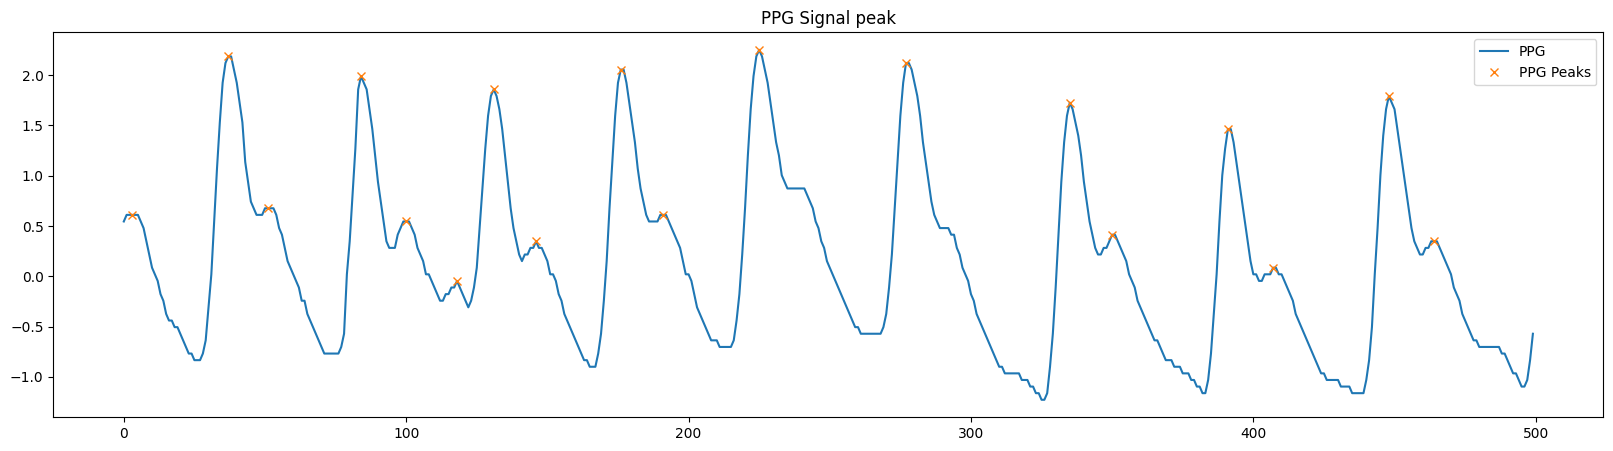

PPG Peaks = 18


In [18]:
from scipy.signal import find_peaks
PPG_peaks, _ = find_peaks(waveform[:500])

plt.figure(figsize=(20,5))
plt.plot(waveform[:500], label='PPG')
plt.plot(PPG_peaks, waveform[PPG_peaks], "x", label='PPG Peaks')
plt.legend()
plt.title("PPG Signal peak")
plt.show()

print(f"PPG Peaks = {len(PPG_peaks)}")

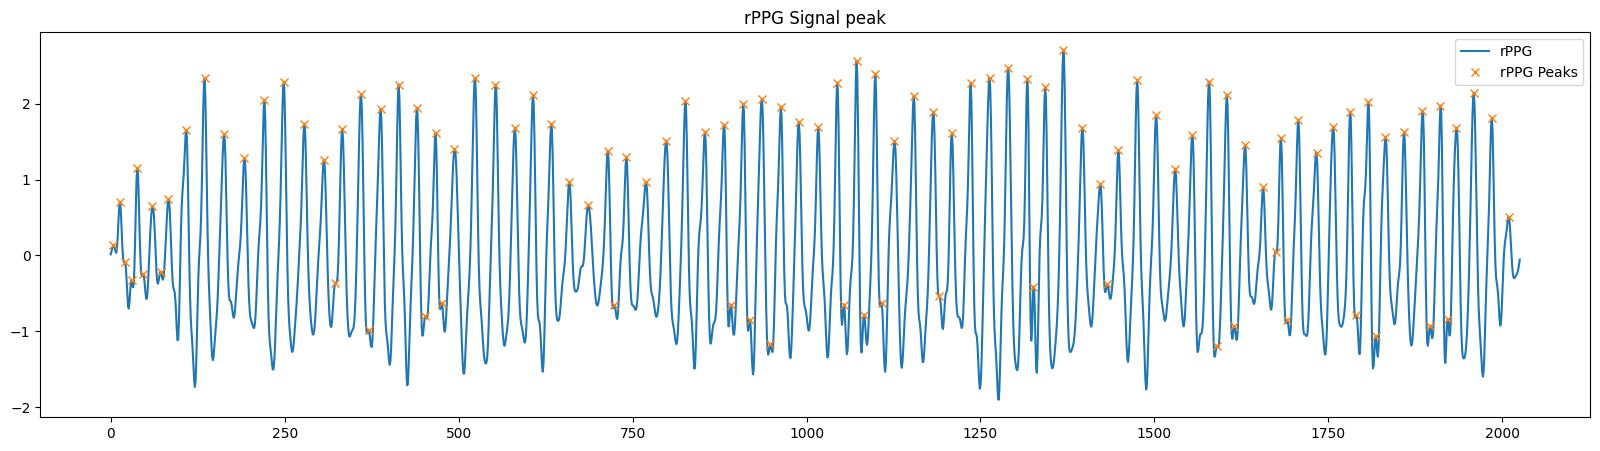

rPPG Peaks = 103


In [19]:
from scipy.signal import find_peaks
rPPG_peaks, _ = find_peaks(rPPG_filtered)

plt.figure(figsize=(20,5))
plt.plot(rPPG_filtered, label='rPPG')
plt.plot(rPPG_peaks, rPPG_filtered[rPPG_peaks], "x", label='rPPG Peaks')
plt.legend()
plt.title("rPPG Signal peak")
plt.show()

print(f"rPPG Peaks = {len(rPPG_peaks[:300])}")

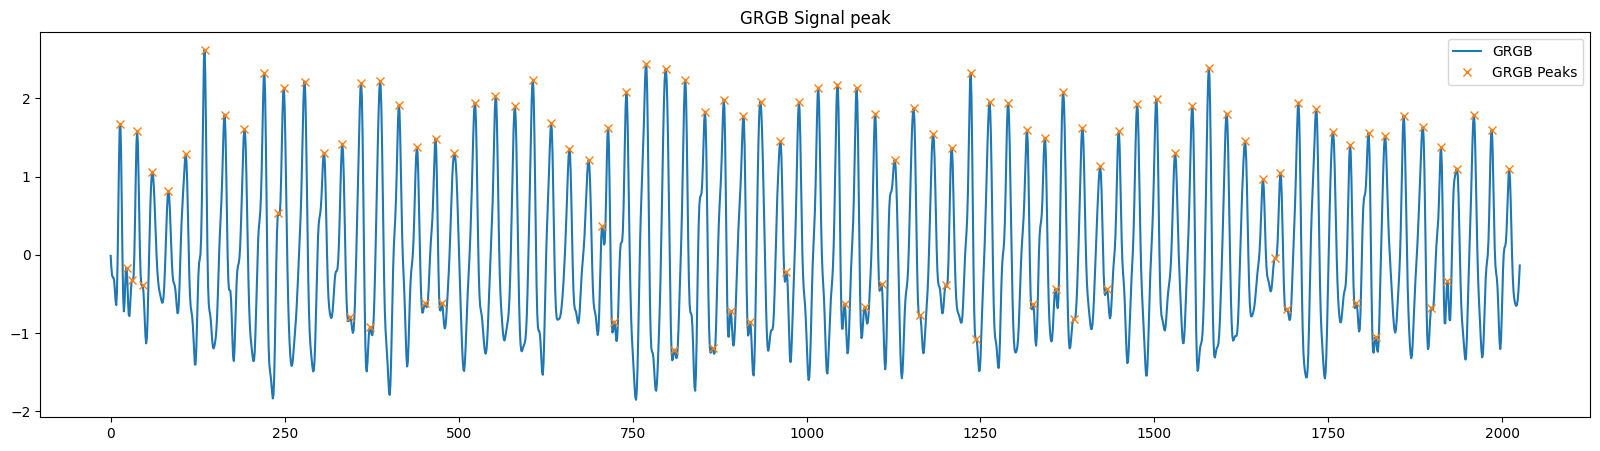

GRGB Peaks = 107


In [20]:
from scipy.signal import find_peaks
GRGB_peaks, _ = find_peaks(GRGB_filtered)

plt.figure(figsize=(20,5))
plt.plot(GRGB_filtered, label='GRGB')
plt.plot(GRGB_peaks, GRGB_filtered[GRGB_peaks], "x", label='GRGB Peaks')
plt.legend()
plt.title("GRGB Signal peak")
plt.show()

print(f"GRGB Peaks = {len(GRGB_peaks)}")

C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 4019 is greater than input length  = 4018, using nperseg = 4018
  warnings.warn('nperseg = {0:d} is greater than input length '


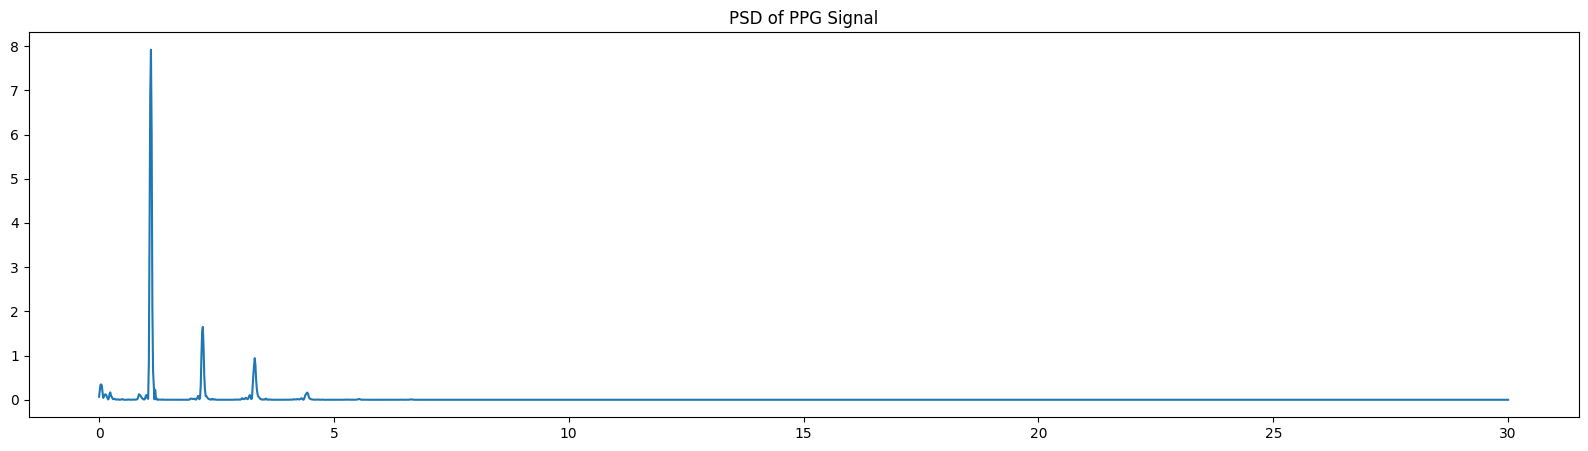

Max Frequency of PPG Signal: 1.1050273768043803
BPM: 66.30164260826282


In [21]:
from scipy.signal import welch

seg_len = (2*waveform.shape[0]) // n_segment + 1

freq_PPG, psd_PPG = welch(waveform, fs=60, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_PPG, psd_PPG)
plt.title("PSD of PPG Signal")
plt.show()

max_freq_PPG =  freq_PPG[np.argmax(psd_PPG)]
print(f"Max Frequency of PPG Signal: {max_freq_PPG}")
PPG_bpm = max_freq_PPG * 60
print(f"BPM: {PPG_bpm}")

C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 2027 is greater than input length  = 2026, using nperseg = 2026
  warnings.warn('nperseg = {0:d} is greater than input length '


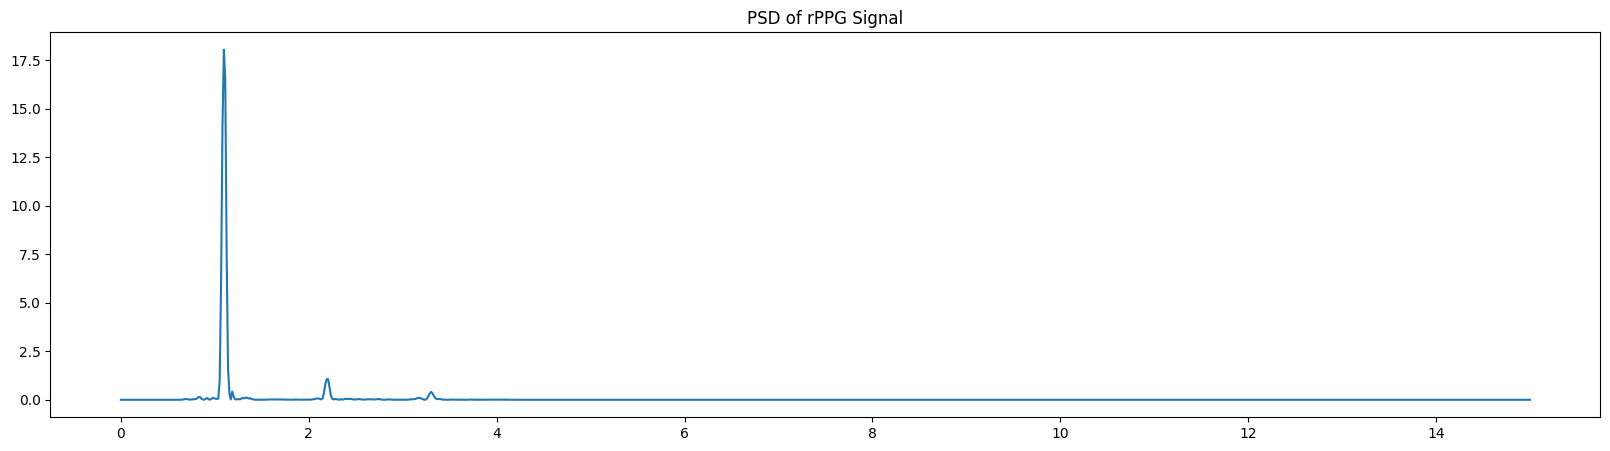

Max Frequency of rPPG Signal: 1.0957551826258638
BPM: 65.74531095755182


In [22]:
from scipy.signal import welch

seg_len = (2*rPPG_filtered.shape[0]) // n_segment + 1

freq_rPPG, psd_rPPG = welch(rPPG_filtered, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_rPPG, psd_rPPG)
plt.title("PSD of rPPG Signal")
plt.show()

max_freq_rPPG =  freq_rPPG[np.argmax(psd_rPPG)]
print(f"Max Frequency of rPPG Signal: {max_freq_rPPG}")
rPPG_bpm = max_freq_rPPG * 60
print(f"BPM: {rPPG_bpm}")

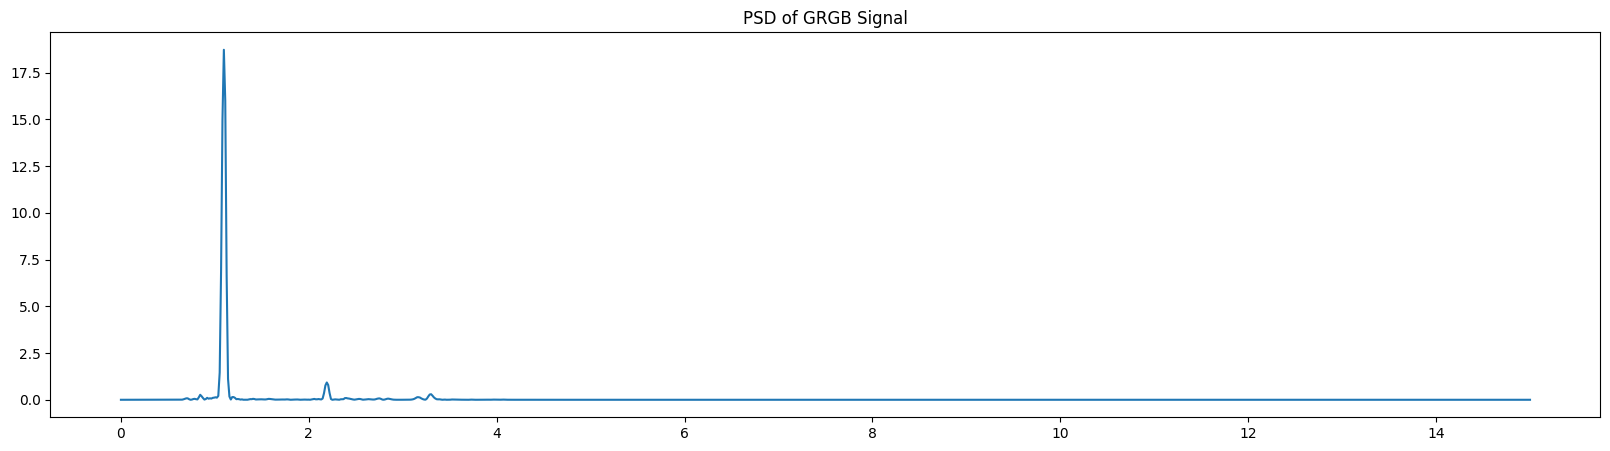

Max Frequency of GRGB Signal: 1.0957551826258638
BPM: 65.74531095755182


In [23]:
from scipy.signal import welch

seg_len = (2*GRGB_filtered.shape[0]) // n_segment + 1

freq_GRGB, psd_GRGB = welch(GRGB_filtered, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_GRGB, psd_GRGB)
plt.title("PSD of GRGB Signal")
plt.show()

max_freq_GRGB =  freq_GRGB[np.argmax(psd_GRGB)]
print(f"Max Frequency of GRGB Signal: {max_freq_GRGB}")
GRGB_bpm = max_freq_GRGB * 60
print(f"BPM: {GRGB_bpm}")

In [24]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import pandas as pd

# 1. Error Metrics (MAE, RMSE, PCC) for heart rate comparison
def evaluate_hr_metrics(ppg_bpm, rppg_bpm):
    # Ensure both sequences are the same length
    ppg_bpm = np.array(ppg_bpm)
    rppg_bpm = np.array(rppg_bpm)
    
    # Compute error metrics
    mae = mean_absolute_error(ppg_bpm, rppg_bpm)
    rmse = np.sqrt(mean_squared_error(ppg_bpm, rppg_bpm))
    pcc, _ = pearsonr(ppg_bpm, rppg_bpm)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Pearson Correlation Coefficient (PCC): {pcc}")
    
    return mae, rmse, pcc

# 2. Load your dataset (assuming it's saved as an .xlsx file)
# Replace 'your_dataset.xlsx' with the path to your actual Excel file
df = pd.read_excel('rPPG_Testing_PURE.xlsx')

# Extract columns: BPM FFT (oxy) for ground truth and POS BPM (YCrCb) for rPPG estimation
oxy_bpm = df['BPM FFT (oxy)']
rppg_bpm = df['POS BPM (YCrCb)']

# 3. Evaluate the metrics
mae, rmse, pcc = evaluate_hr_metrics(oxy_bpm, rppg_bpm)

# Optional: Print the first few rows to confirm
# print(df)


Mean Absolute Error (MAE): 0.7191457016850102
Root Mean Square Error (RMSE): 1.029175150431185
Pearson Correlation Coefficient (PCC): 0.9994582718758561


In [25]:
def calculate_accuracy(ppg_bpm, rppg_bpm, threshold):
    ppg_bpm = np.array(ppg_bpm)
    rppg_bpm = np.array(rppg_bpm)

    # Count correct predictions within the threshold
    correct_predictions = np.sum(np.abs(ppg_bpm - rppg_bpm) <= threshold)
    accuracy = (correct_predictions / len(ppg_bpm)) * 100
    
    return accuracy

threshold = 2
accuracy = calculate_accuracy(oxy_bpm, rppg_bpm, threshold)
print(f"Accuracy (within {threshold} BPM): {accuracy:.2f}%")

Accuracy (within 2 BPM): 96.61%


In [26]:
def calculate_mape(ppg_bpm, rppg_bpm):
    ppg_bpm = np.array(ppg_bpm)
    rppg_bpm = np.array(rppg_bpm)

    # Count correct predictions within the threshold
    # non_zero_actual = ppg_bpm != 0
    mape = np.mean(np.abs((ppg_bpm - rppg_bpm) / ppg_bpm)) * 100
    
    return mape

mape = calculate_mape(oxy_bpm, rppg_bpm)
print(f"mape:{mape:.2f}%")

mape:1.01%


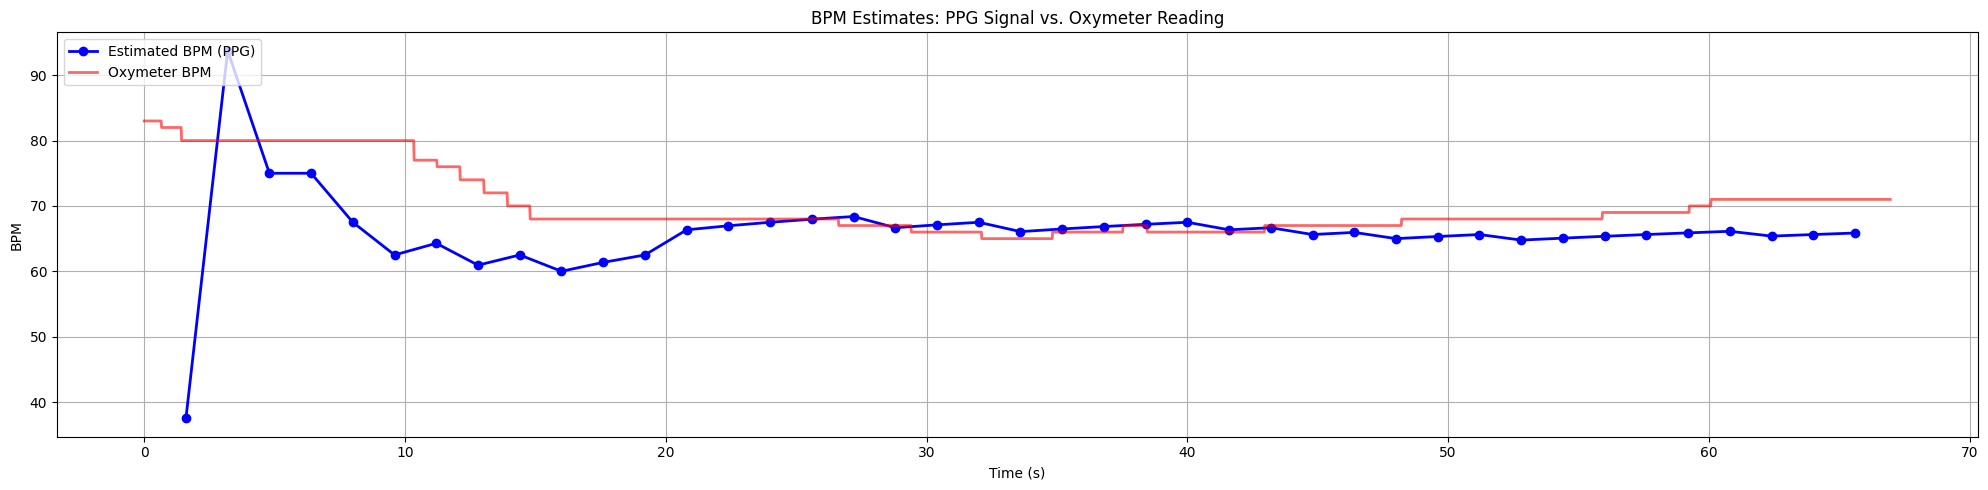

Window 1 (from 0s to 1.60s): BPM = 37.50
Window 2 (from 0s to 3.20s): BPM = 93.75
Window 3 (from 0s to 4.80s): BPM = 75.00
Window 4 (from 0s to 6.40s): BPM = 75.00
Window 5 (from 0s to 8.00s): BPM = 67.50
Window 6 (from 0s to 9.60s): BPM = 62.50
Window 7 (from 0s to 11.20s): BPM = 64.29
Window 8 (from 0s to 12.80s): BPM = 60.94
Window 9 (from 0s to 14.40s): BPM = 62.50
Window 10 (from 0s to 16.00s): BPM = 60.00
Window 11 (from 0s to 17.60s): BPM = 61.36
Window 12 (from 0s to 19.20s): BPM = 62.50
Window 13 (from 0s to 20.80s): BPM = 66.35
Window 14 (from 0s to 22.40s): BPM = 66.96
Window 15 (from 0s to 24.00s): BPM = 67.50
Window 16 (from 0s to 25.60s): BPM = 67.97
Window 17 (from 0s to 27.20s): BPM = 68.38
Window 18 (from 0s to 28.80s): BPM = 66.67
Window 19 (from 0s to 30.40s): BPM = 67.11
Window 20 (from 0s to 32.00s): BPM = 67.50
Window 21 (from 0s to 33.60s): BPM = 66.07
Window 22 (from 0s to 35.20s): BPM = 66.48
Window 23 (from 0s to 36.80s): BPM = 66.85
Window 24 (from 0s to 38.4

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Parameters
fs = 60  # Sampling rate in Hz (samples per second)
step_time = 1.6  # Step size for window expansion in seconds
step_size = int(step_time * fs)  # Step size in samples

# Store the BPM estimates
bpm_estimates = []
time_window = []

# Expanding window approach for PSD and BPM calculation
for end in range(step_size, len(waveform) + 1, step_size):
    # Window from 0 to the current end point
    window_trace = waveform[:end]
    
    # PSD calculation using Welch's method
    freq_PPG, psd_PPG = welch(window_trace, fs=fs, window='flattop', nperseg=len(window_trace))
    
    # Find the frequency with the maximum power
    max_freq_PPG = freq_PPG[np.argmax(psd_PPG)]
    
    # Convert the frequency to BPM
    PPG_bpm = max_freq_PPG * 60
    bpm_estimates.append(PPG_bpm)
    
    # Store the current time window (in seconds)
    time_window.append(end / fs)

# Plotting the BPM estimates and oxymeter BPM on the same y-axis
plt.figure(figsize=(20, 5))

# Plot BPM estimates from the PPG signal
plt.plot(time_window, bpm_estimates, marker='o', color='blue', label='Estimated BPM (PPG)', linewidth=2)

# Plot the oxymeter readings for comparison
plt.plot(np.arange(len(pulseRate)) / fs, pulseRate, color='red', alpha=0.6, label='Oxymeter BPM', linewidth=2)

# Configure plot
plt.title("BPM Estimates: PPG Signal vs. Oxymeter Reading")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend(loc="upper left")
plt.grid()

# Show plot
plt.tight_layout()
plt.show()

# Print the BPM estimates
for i, bpm in enumerate(bpm_estimates):
    print(f"Window {i+1} (from 0s to {time_window[i]:.2f}s): BPM = {bpm:.2f}")


In [41]:
import pandas as pd

# Replace 'your_file.xlsx' with the path to your Excel file
file_path = 'rPPG_Testing_PURE.xlsx'

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path)

df['Difference'] = df['BPM FFT (oxy)'] - df['POS BPM (HSCbCr)']

df_filtered = df[df['Difference'].abs() > 10]
print(df_filtered)

   Unnamed: 0  mean BPM (Oximeter)  BPM FFT (oxy)    POS BPM   GRGB BPM  \
48      09-02            50.815212      53.865337  53.544869  52.652454   
49      09-03            48.310960      48.327465  47.264770  58.293217   

    POS BPM (YCrCb)  GRGB BPM (YCrCb)  POS BPM (HSV)  GRGB BPM (HSV)  \
48        53.544869         52.652454      49.082796       56.222112   
49        48.052516         48.052516      67.746171       47.264770   

    POS BPM (HSCbCr)  GRGB BPM (HSCbCr)  Difference  
48         65.146257          53.544869   -11.28092  
49         66.958425          48.052516   -18.63096  
